In [1]:
import numpy as np
import scipy.linalg as la

from qiskit import execute
from qiskit import Aer
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel

from racbem import *

import os
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/anaconda3/envs/quantum/lib/python3.7/site-packages/qiskit/validation/fields/custom.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.integer, numpy.float,
/Users/flynn_chen/.pyxbld/temp.macosx-10.9-x86_64-3.7/pyrex/qutip/cy/openmp/parfuncs.cpp:636:10: fatal error: 'src/zspmv_openmp.hpp' file not found
#include "src/zspmv_openmp.hpp"
         ^~~~~~~~~~~~~~~~~~~~~~
1 error generated.


In [2]:
def GetBackend(backend_name=None):
    if backend_name == None:
        backend = Aer.get_backend('unitary_simulator')
        #backend = Aer.get_backend('qasm_simulator')
    else:
        provider = IBMQ.load_account()
        backend = provider.get_backend(backend_name)
    return backend

To get consistent output:
1. remove random noise (sigma=0)
2. set seed = 0, and added seed in the build_random_circuit

In [3]:
backend_name = 'ibmq_burlington'
#backend_name = None
kappa = 5                   # condition number
n_sys_qubit = 3             # the number of system qubits
n_be_qubit = 1              # the number of block-encoding qubit
n_sig_qubit = 1             # the number of signal qubit
n_tot_qubit = n_sig_qubit+n_be_qubit+n_sys_qubit
n_depth = 15                # the depth of random circuit
prob_one_q_op = 0.5         # the probability of selecting a one-qubit
                            # operation when two_q_op is allowed
basis_gates = ['u1','u2','cx']
digit_shots = 13
n_shots = 2**digit_shots    # the number of shots used in measurements
sigma = 0                # parameter used to rescale noise model
# state |0^n>
b = np.zeros((2**n_sys_qubit,))
b[0] = 1.0
load_architecture = True    # True:     load architure locally
                            # False:    need to save an IBM account beforehand

In [4]:
seed = 0
np.random.seed(seed)

# instances of RACBEM
be = BlockEncoding(n_be_qubit, n_sys_qubit)
qsp = QSPCircuit(n_sig_qubit, n_be_qubit, n_sys_qubit)

# retrieve backends and architectures
backend = GetBackend()
if load_architecture:
    if os.path.exists(backend_name+'_backend_config.pkl'):
        noise_backend = pickle.load(open(backend_name+'_backend_config.pkl','rb'))
        noise_model = NoiseModel.from_dict(noise_backend['noise_dict'])
        coupling_map = noise_backend['coupling_map']
        tot_q_device = noise_backend['tot_q_device']
        print("\nload architecture locally at: %s_backend_config.pkl\n"%(backend_name))
    else:
        raise Exception("no locally saved architecture: %s_backend_config.pkl"%(backend_name), load_architecture)
else:
    noise_backend = GetBackend(backend_name=backend_name)
    coupling_map = noise_backend.configuration().coupling_map
    noise_model = NoiseModel.from_backend(noise_backend)
    tot_q_device = noise_backend.configuration().n_qubits
    pickle.dump({'noise_dict': noise_model.to_dict(), 'coupling_map': coupling_map, 'tot_q_device': tot_q_device, 
                'basis_gates': noise_backend.configuration().basis_gates}, open(backend_name+'_backend_config.pkl','wb'))
    print("retrieve architecture from IBM Q and save locally at: %s_backend_config.pkl\n"%(backend_name))
assert tot_q_device >= n_tot_qubit
new_noise_model = scale_noise_model(noise_model, sigma)

# exclude qubit 0 as signal qubit, shift the remaining labels by -1
be_map = [[q[0]-1,q[1]-1] for q in coupling_map if (0 not in q) and 
        (q[0] < n_tot_qubit) and (q[1] < n_tot_qubit)]
be.build_random_circuit(n_depth, basis_gates=basis_gates, 
        prob_one_q_op=prob_one_q_op, coupling_map=be_map, seed=seed)
be.build_dag()

# load phase factors
data = np.loadtxt("phi_inv_%d.txt"%(kappa))
phi_seq = data[:-2]
#phi_seq = np.random.rand(7) * np.pi
#phi_seq = np.pi/(2**np.arange(0, 15))
scale_fac = data[-2]
app_err = data[-1]

# retrieve block-encoded matrix
UA = retrieve_unitary_matrix(be.qc)
A = UA[0:2**n_sys_qubit, 0:2**n_sys_qubit]
(svd_U, svd_S, svd_VH) = la.svd(A)
print("kappa=%d, sigma=%.2f, polynomial approximation error=%.3e"%(kappa, sigma, app_err))
print("")
print("Generic RACBEM")
print("singular value (A) = \n", np.around(svd_S, decimals=3))

# succ prob via measurement
qsp.build_circuit(be.qc, be.qc_dag, phi_seq, realpart=True, measure=False)
compiled_circ = qsp.qcircuit
job = execute(compiled_circ, backend=backend, shots=n_shots)
job_monitor(job)
result = job.result()
counts = result.get_counts(compiled_circ)

# both the signal and the ancilla qubit for block-encoding needs to
# be 0
prob_meas = np.float(counts['00']) / n_shots
# succ prob via noiseless simulator
qsp.build_circuit(be.qc, be.qc_dag, phi_seq, realpart=True, measure=False)
state = retrieve_state(qsp.qcircuit)
x = state[0:2**n_sys_qubit]
prob_qsp = la.norm(x)**2

# exact succ prob
svd_S_herm = (1-1.0/kappa)*svd_S**2+1.0/kappa
A_herm_inv = svd_VH.transpose().conjugate() @ np.diag(1/svd_S_herm) @ svd_VH
x_exact = A_herm_inv @ b / scale_fac
prob_exact = la.norm(x_exact)**2
print("succ prob (exact)     = ", prob_exact)
print("succ prob (noiseless) = ", prob_qsp)
print("succ prob (measure)   = ", prob_meas)
print("")



load architecture locally at: ibmq_burlington_backend_config.pkl

kappa=5, sigma=0.00, polynomial approximation error=1.902e-02

Generic RACBEM
singular value (A) = 
 [0.993 0.993 0.993 0.993 0.118 0.118 0.118 0.118]
Job Status: job has successfully run
succ prob (exact)     =  0.34082677237212344
succ prob (noiseless) =  0.3335402677866099
succ prob (measure)   =  0.0001220703125



In [5]:
#np.save("A.npy", A)
#A
original_A = np.load("A.npy")
print(A)
print(la.norm(A - original_A))
# Original Deterministic A:
# [[ 0.01591595-0.06091262j -0.04364085+0.04373186j  0.02314171-0.06926542j
#    0.06366198-0.07879893j -0.093819  +0.10032052j -0.40889301+0.08239013j
#   -0.04195223+0.09199068j  0.35671694-0.0358126j ]
#  [-0.03648155+0.10957695j  0.01290732-0.12027733j  0.04606855-0.04155211j
#    0.00724757-0.11006332j -0.01862191-0.06483394j -0.37372645+0.01786421j
#    0.23794145+0.00468263j -0.39109522+0.01304492j]

[[-0.01404601-0.11184532j  0.19180473+0.0802008j  -0.107059  +0.12677166j
  -0.10058599-0.39550207j -0.22867858+0.05206108j -0.06838909-0.0723547j
   0.13327245-0.22391818j -0.01494765-0.34199292j]
 [-0.02867275+0.05600864j  0.20953192-0.08980629j  0.02405063+0.35594784j
   0.23012008+0.11764165j -0.05202287+0.2302033j  -0.01267472-0.09516265j
   0.18314212+0.35976273j -0.13332603-0.06585891j]
 [ 0.25415988+0.04687823j  0.31454964-0.16833249j -0.12042226-0.19356465j
   0.0117483 -0.06181482j -0.04496685+0.14174346j -0.27700226-0.29366649j
  -0.03937392-0.08755726j  0.23122597-0.04727038j]
 [-0.26291985+0.31210989j -0.00897496-0.16568685j -0.20710959+0.01807868j
   0.0831088 -0.07615506j  0.17210589+0.29590903j  0.25974536-0.02081449j
  -0.01898643+0.09773323j  0.13078357-0.19467898j]
 [ 0.24614676+0.09777777j  0.30782014-0.17079273j -0.06956121-0.22468632j
   0.00222636+0.02449958j -0.0523335 +0.15846874j -0.08530025-0.3872418j
  -0.08427135-0.0886162j   0.13606533+0.17733655j]
 [-0.28

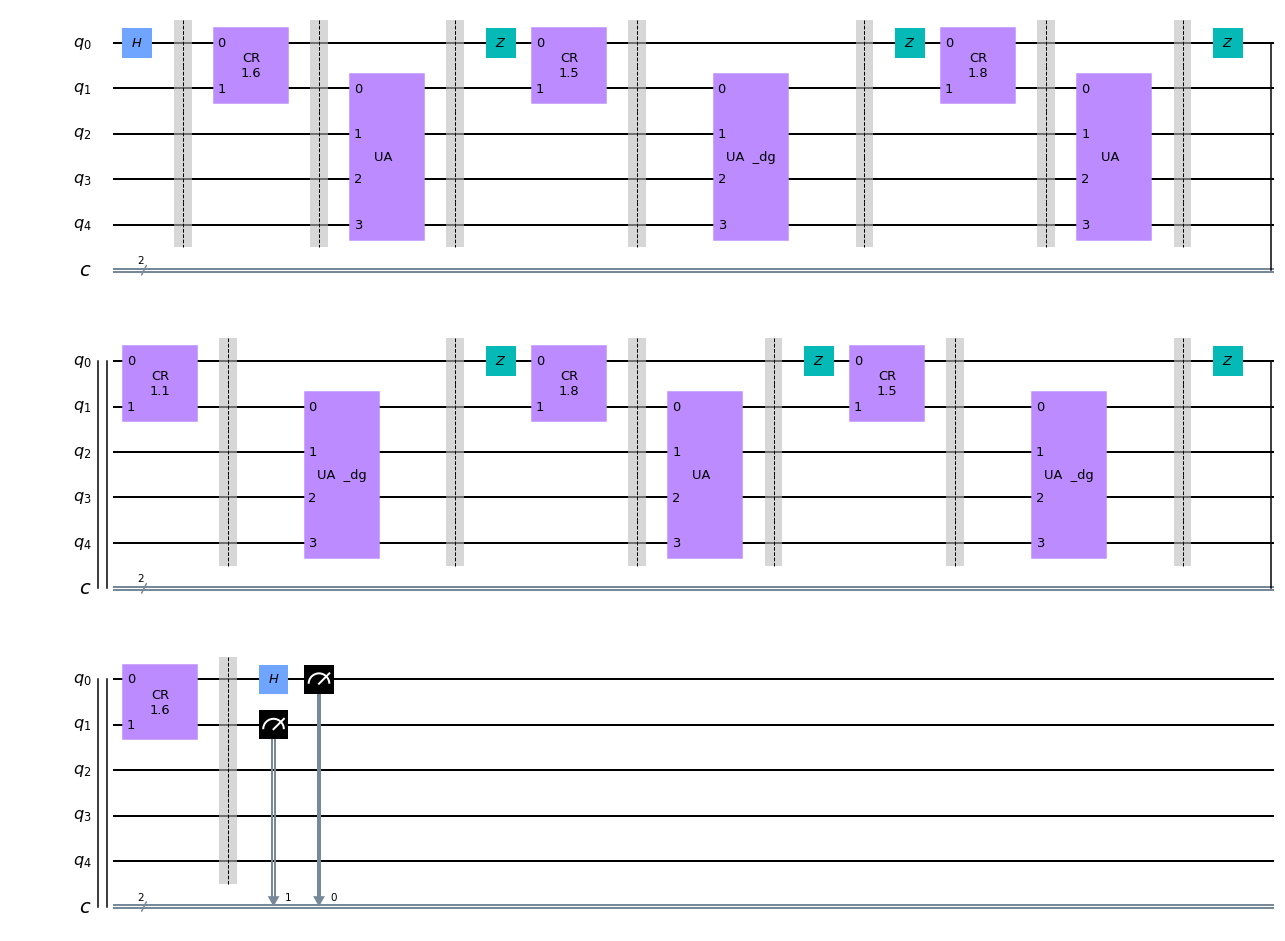

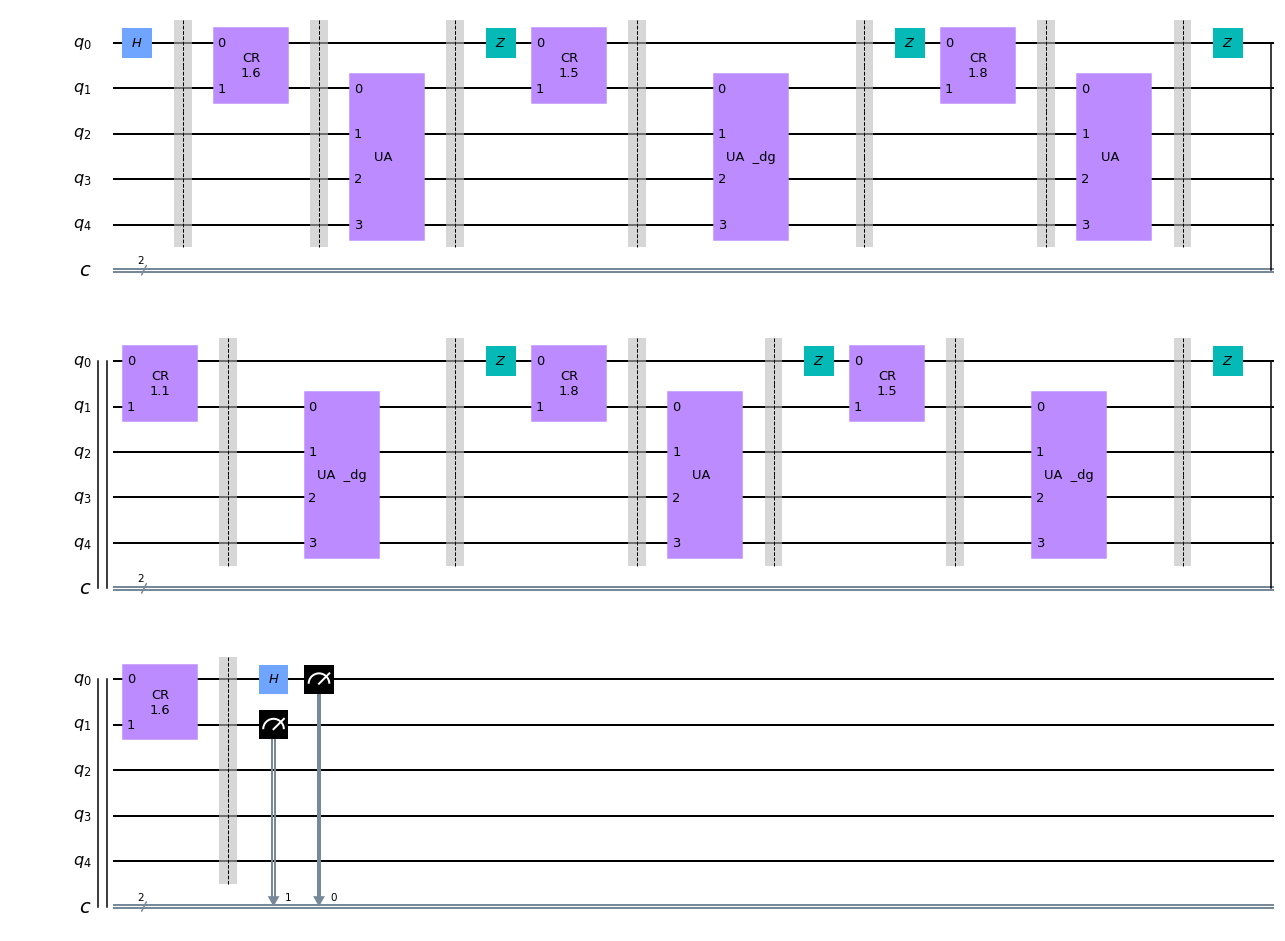

In [7]:
qsp.qcircuit.draw(output='mpl')

In [9]:
result.get_unitary(compiled_circ, decimals=3)

array([[-0.073-0.475j,  0.196-0.03j , -0.   -0.j   , ..., -0.   +0.j   ,
        -0.   +0.j   ,  0.026+0.208j],
       [ 0.196-0.03j , -0.073-0.475j, -0.204-0.172j, ..., -0.   -0.j   ,
         0.026+0.208j, -0.   -0.j   ],
       [-0.   +0.j   , -0.143+0.225j, -0.073-0.475j, ..., -0.182+0.103j,
        -0.   +0.j   , -0.   -0.j   ],
       ...,
       [ 0.   +0.j   ,  0.   +0.j   , -0.205-0.044j, ..., -0.073-0.475j,
         0.153+0.218j, -0.   +0.j   ],
       [ 0.   -0.j   , -0.038-0.206j, -0.   -0.j   , ...,  0.081-0.254j,
        -0.073-0.475j, -0.196+0.03j ],
       [-0.038-0.206j, -0.   -0.j   ,  0.   -0.j   , ..., -0.   +0.j   ,
        -0.196+0.03j , -0.073-0.475j]])